# Normal vs Heart Attack Classification Model using ECGs

## Get the Data

In [1]:
# Install Python dependencies
!pip install tensorflow numpy scipy scikit-learn pandas wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.6 MB/s eta 0:00:00


In [33]:
# Dataset Originally from here: https://www.physionet.org/content/ptb-xl/1.0.3/records500/21000/
# The dataset is saved in a google drive folder, and was preprocessed to only contain the second
# lead sampled at 100Hz.
import os
import numpy as np
from google.colab import drive

# Mount google drive
MOUNT_DIR = "/content/drive"
drive.mount('/content/drive/')

# Load the saved data
DATA_PATH = os.path.join(MOUNT_DIR, "MyDrive", "datasets", "ecg.npz")
data = np.load(DATA_PATH)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Preprocess the Dataset

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

def compute_p2p_stats(signals):
  p2p_voltages = np.max(signals, axis=1) - np.min(signals, axis=1)
  mean = np.mean(p2p_voltages)
  median = np.median(p2p_voltages)
  std = np.std(p2p_voltages)
  return p2p_voltages, mean, median, std

def plot_histogram(p2p, mean, median, std, num_stds, title):
  plt.clf()
  plt.hist(p2p, bins=20)
  plt.axvline(x=mean, c="r", label="mean")
  plt.axvline(x=median, c="k", label="median")
  plt.axvline(x=median+(std*num_stds), c="b", label=f"+/-{num_stds} Standard Deviations")
  plt.axvline(x=median-(std*num_stds), c="b")
  plt.title(title)
  plt.xlabel("p2p voltages")
  plt.legend()
  plt.show()


norm, mi = data["arr_0"], data["arr_1"]

p2p_norm, mean_norm, median_norm, std_norm = compute_p2p_stats(norm)
p2p_mi, mean_mi, median_mi, std_mi = compute_p2p_stats(mi)


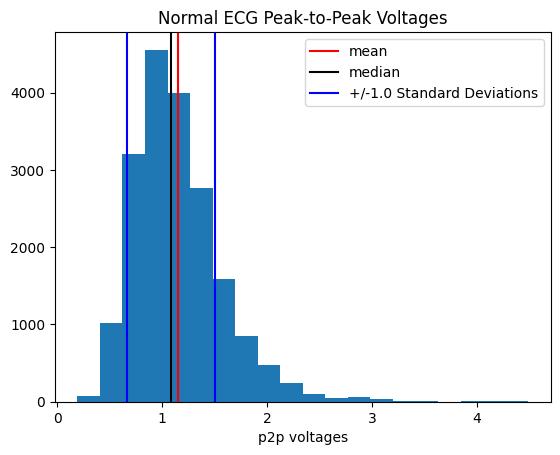

In [35]:
nstds_norm = 1.
plot_histogram(p2p_norm, mean_norm, median_norm, std_norm, nstds_norm, "Normal ECG Peak-to-Peak Voltages")

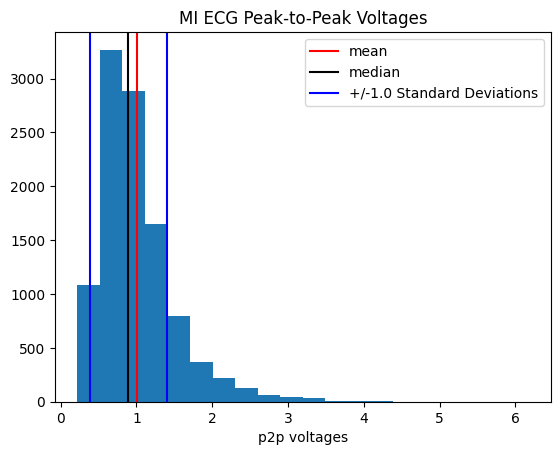

In [36]:
nstds_mi = 1.
plot_histogram(p2p_mi, mean_mi, median_mi, std_mi, nstds_mi, "MI ECG Peak-to-Peak Voltages")

In [6]:
# Drop data outside 1 standard deviation
keep_mask_norm = np.abs(p2p_norm - median_norm) <= std_norm
keep_mask_mi = np.abs(p2p_mi - median_mi) <= std_mi

print(f"Keeping {np.sum(keep_mask_norm)} / {p2p_norm.size} of normal ECGs")
print(f"Keeping {np.sum(keep_mask_mi)} / {p2p_mi.size} of MI ECGs")

norm_filtered = norm[keep_mask_norm]
mi_filtered = mi[keep_mask_mi]

print(f"Norm Matrix Shape: {norm_filtered.shape}")
print(f"MI Matrix Shape: {mi_filtered.shape}")

Keeping 14340 / 19028 of normal ECGs
Keeping 8616 / 10574 of MI ECGs
Norm Matrix Shape: (14340, 1000)
MI Matrix Shape: (8616, 1000)


In [7]:
# Combine data into one representation
X = np.expand_dims(np.vstack((norm_filtered, mi_filtered)), axis=1)
y = np.vstack([
      np.zeros(shape=(norm_filtered.shape[0], 1), dtype=int),
      np.ones(shape=(mi_filtered.shape[0], 1), dtype=int)
    ])

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (22956, 1, 1000)
y Shape: (22956, 1)


## Split the Dataset

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Split the training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Split the training set further into train and deployment
X_train, X_deploy, y_train, y_deploy = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

# Convert all the datasets into TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)
X_deploy = tf.convert_to_tensor(X_deploy)
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)
y_deploy = tf.convert_to_tensor(y_deploy)


## Build and Train a Deep Learning Model

In [18]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation=None, data_format="channels_first", input_shape=(1, 1000)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation=None, data_format="channels_first"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=16, kernel_size=4, activation=None, data_format="channels_first"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=8, kernel_size=3, activation=None, data_format="channels_first"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 64, 993)           576       
                                                                 
 batch_normalization_9 (Bat  (None, 64, 993)           3972      
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 64, 993)           0         
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 32, 993)           0         
 ng1D)                                                           
                                                                 
 conv1d_26 (Conv1D)          (None, 32, 988)           6176      
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 32, 988)          

In [19]:
history = model.fit(X_train, y_train, batch_size=4, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25
3680/3680 [==============================] - 37s 7ms/step - loss: 0.4761 - accuracy: 0.7849 - val_loss: 0.4123 - val_accuracy: 0.8176
Epoch 2/25
3680/3680 [==============================] - 29s 8ms/step - loss: 0.3410 - accuracy: 0.8559 - val_loss: 0.6270 - val_accuracy: 0.8267
Epoch 3/25
3680/3680 [==============================] - 30s 8ms/step - loss: 0.1955 - accuracy: 0.9288 - val_loss: 0.4941 - val_accuracy: 0.8902
Epoch 4/25
3680/3680 [==============================] - 28s 8ms/step - loss: 0.0850 - accuracy: 0.9693 - val_loss: 0.4523 - val_accuracy: 0.9049
Epoch 5/25
3680/3680 [==============================] - 27s 7ms/step - loss: 0.0630 - accuracy: 0.9795 - val_loss: 0.3578 - val_accuracy: 0.9231
Epoch 6/25
3680/3680 [==============================] - 27s 7ms/step - loss: 0.0526 - accuracy: 0.9841 - val_loss: 0.5364 - val_accuracy: 0.9255
Epoch 7/25
3680/3680 [==============================] - 28s 8ms/step - loss: 0.0485 - accuracy: 0.9857 - val_loss: 0.6081 - val_ac

In [20]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=4)
print(f"Test Accuracy: {test_accuracy*100:.2f}")

574/574 [==============================] - 3s 5ms/step - loss: 1.0250 - accuracy: 0.9290
Test Accuracy: 92.90


## Visualize the Results

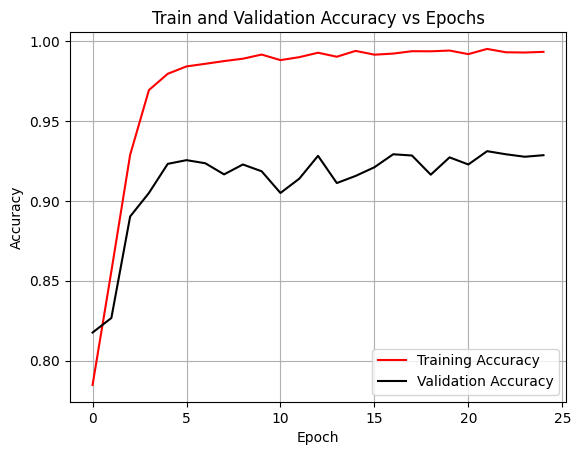

In [27]:
# Plot the accuracy over time
plt.plot(history.history["accuracy"], c="r", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], c="k", label="Validation Accuracy")
plt.title("Train and Validation Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc="lower right")


## Save the Model and Deployment Dataset

In [28]:
!pip install pyyaml h5py

In [29]:
import os

# Save the model
path_to_save = os.path.join(MOUNT_DIR, "MyDrive", "datasets", "model")
model.save(path_to_save)

In [31]:
# Save the deployment dataset as numpy arrays
path_to_save = os.path.join(MOUNT_DIR, "MyDrive", "datasets", "deploy.npz")
np.savez(path_to_save, ecgs=X_deploy.numpy(), labels=y_deploy.numpy())